# Stonks 

Use tensorflow to build deep learning based time series forcasting models based on financial data.

Try out different neural network architectures, see which one works best for this task.

Keep track of the performance of all of the models.

Read the official Tensorflow time series forecasting [guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [12]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf

In [13]:
mpl.rcParams['figure.figsize'] = (16, 9)

### Dataset

Currently using `yfinance` to access yahoo finance historical data since it is free.

In [14]:
tickers = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'QQQ', 'TQQQ', 'SPY', 'TSLA', 'BABA', 'JETS', 'COST', 'AMD', 'NVDA', 'DIS', 'WWR', 'SNAP']
tickers

['FB',
 'AAPL',
 'AMZN',
 'NFLX',
 'GOOG',
 'QQQ',
 'TQQQ',
 'SPY',
 'TSLA',
 'BABA',
 'JETS',
 'COST',
 'AMD',
 'NVDA',
 'DIS',
 'WWR',
 'SNAP']

In [15]:
def create_yfinance_df(tickers):
    return yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = '1y',

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = '1d',

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )


In [16]:
multi_index_column_ticker_df = create_yfinance_df(tickers)

[*********************100%***********************]  17 of 17 completed


What do the first few entries look like? These should be the oldest.

In [17]:
multi_index_column_ticker_df.head()

SNAP                                              WWR        \
                 Open       High        Low      Close    Volume  Open  High   
Date                                                                           
2019-12-30  16.049999  16.170000  15.680000  15.890000  15608200  2.24  2.24   
2019-12-31  15.780000  16.350000  15.770000  16.330000  18046200  2.13  2.23   
2020-01-02  16.620001  16.950001  16.459999  16.780001  26062600  2.12  2.39   
2020-01-03  16.430000  17.100000  16.350000  16.750000  19761500  2.28  2.34   
2020-01-06  16.650000  16.790001  16.410000  16.780001  15952600  2.35  2.45   

                                ...        AMD                        \
             Low Close  Volume  ...       Open       High        Low   
Date                            ...                                    
2019-12-30  2.15  2.17   79400  ...  46.139999  46.169998  44.660000   
2019-12-31  2.11  2.11  101400  ...  45.070000  46.090000  44.919998   
2020-01-02  2.10  2.35  225300  ...  46.860001  49.250000  46.630001   
2020-01-03  2.12  2.31  154800  ...  48.029999  49.389999  47.540001   
2020-01-06  2.25  2.30  186900  ...  48.020000  48.860001  47.860001   

                                        SPY                          \
                Close    Volume        Open        High         Low   
Date                                                                  
2019-12-30  45.520000  41149700  317.029561  317.176805  314.673535   
2019-12-31  45.860001  31673200  314.653899  316.224573  314.280860   
2020-01-02  49.099998  80331100  317.608702  318.933959  316.617208   
2020-01-03  48.599998  73127400  315.272366  317.706913  315.213469   
2020-01-06  48.389999  47934900  314.614632  317.795256  314.487011   

                                  
                 Close    Volume  
Date                              
2019-12-30  315.193817  49729100  
2019-12-31  315.959503  57077300  
2020-01-02  318.914307  59151200  
2020-01-03  316.499451  77709700  
2020-01-06  317.706909  55653900  

[5 rows x 85 columns]

What do the last few entries look like? These should be the newest.

In [18]:
multi_index_column_ticker_df.tail()

SNAP                                              WWR        \
                 Open       High        Low      Close    Volume  Open  High   
Date                                                                           
2020-12-22  52.590000  53.305000  50.799999  52.090000  16249400  5.23  5.83   
2020-12-23  52.139999  53.790001  51.500000  51.740002  12929300  5.91  6.42   
2020-12-24  51.919998  51.980000  49.880001  50.150002   9450400  5.54  5.64   
2020-12-28  50.770000  50.830002  47.820000  48.259998  13703800  5.47  5.53   
2020-12-29  51.480000  53.779999  50.459999  51.230000  49394285  5.24  5.27   

                                 ...        AMD                        \
             Low Close   Volume  ...       Open       High        Low   
Date                             ...                                    
2020-12-22  5.15  5.82  7968600  ...  93.360001  93.550003  90.529999   
2020-12-23  5.33  5.51  9868500  ...  93.080002  93.129997  91.459999   
2020-12-24  5.24  5.37  2088700  ...  91.800003  92.510002  91.309998   
2020-12-28  5.16  5.27  2465700  ...  92.930000  93.139999  90.820000   
2020-12-29  4.82  4.95  3756947  ...  91.660004  92.449997  89.430099   

                                        SPY                          \
                Close    Volume        Open        High         Low   
Date                                                                  
2020-12-22  93.160004  35673700  368.209991  368.329987  366.029999   
2020-12-23  91.550003  25993300  368.279999  369.619995  367.220001   
2020-12-24  91.809998  16705900  368.079987  369.029999  367.450012   
2020-12-28  91.599998  30572600  371.739990  372.589996  371.070007   
2020-12-29  90.620003  31595704  373.809998  374.000000  370.829987   

                                  
                 Close    Volume  
Date                              
2020-12-22  367.239990  47949000  
2020-12-23  367.570007  46201400  
2020-12-24  369.000000  26457900  
2020-12-28  372.170013  38851900  
2020-12-29  371.459991  46798774  

[5 rows x 85 columns]

In [19]:
multi_index_column_ticker_df.dtypes

SNAP  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
                 ...   
SPY   Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume      int64
Length: 85, dtype: object

In [20]:
multi_index_column_ticker_df.describe().transpose()

count          mean           std           min           25%  \
SNAP Open    253.0  2.424340e+01  1.124437e+01  8.030000e+00  1.705000e+01   
     High    253.0  2.485045e+01  1.153512e+01  9.080000e+00  1.753000e+01   
     Low     253.0  2.369876e+01  1.097385e+01  7.890000e+00  1.665000e+01   
     Close   253.0  2.431656e+01  1.126298e+01  8.370000e+00  1.713000e+01   
     Volume  253.0  3.005718e+07  2.612541e+07  7.690700e+06  1.835470e+07   
...            ...           ...           ...           ...           ...   
SPY  Open    253.0  3.175833e+02  3.241541e+01  2.253239e+02  2.998065e+02   
     High    253.0  3.202688e+02  3.112067e+01  2.267952e+02  3.034923e+02   
     Low     253.0  3.147720e+02  3.338814e+01  2.155187e+02  2.948496e+02   
     Close   253.0  3.175973e+02  3.224103e+01  2.201497e+02  2.997177e+02   
     Volume  253.0  1.002595e+08  6.894390e+07  2.645790e+07  5.769860e+07   

                      50%           75%           max  
SNAP Open    2.176000e+01  2.592000e+01  5.368000e+01  
     High    2.201000e+01  2.650000e+01  5.471000e+01  
     Low     2.126000e+01  2.577000e+01  5.242000e+01  
     Close   2.170000e+01  2.611000e+01  5.333000e+01  
     Volume  2.444570e+07  3.232690e+07  2.543631e+08  
...                   ...           ...           ...  
SPY  Open    3.214667e+02  3.384672e+02  3.738100e+02  
     High    3.239601e+02  3.401799e+02  3.784600e+02  
     Low     3.202748e+02  3.347771e+02  3.710700e+02  
     Close   3.221269e+02  3.373756e+02  3.721700e+02  
     Volume  7.573800e+07  1.138456e+08  3.922207e+08  

[85 rows x 8 columns]

We know that we currently have a multiindex dataframe, but I want to flatten this into a single flat dataframe so it is easier to work with. We can use `to_flat_index()` on our dataframe's columns to accomplish this.

In [21]:
print(type(multi_index_column_ticker_df.columns))

<class 'pandas.core.indexes.multi.MultiIndex'>


In [22]:
def flatten_multi_index_column_df(df):
    if type(df.columns) is not pd.core.indexes.multi.MultiIndex:
        raise Exception('provided dataframe does not have multiindex columns')
    tuple_column_flattener = lambda tup: f'{tup[0].lower()}_{tup[1].lower()}'
    flattened_columns = df.columns.to_flat_index().map(tuple_column_flattener)
    flattened_df = df.copy() # I don't like mutating the original dataframe, yes this more memory intensive
    flattened_df.columns = flattened_columns
    return flattened_df

In [23]:
flattened_df = flatten_multi_index_column_df(multi_index_column_ticker_df)

In [24]:
flattened_df.head()

,snap_open,snap_high,snap_low,snap_close,snap_volume,wwr_open,wwr_high,wwr_low,wwr_close,wwr_volume,...,amd_open,amd_high,amd_low,amd_close,amd_volume,spy_open,spy_high,spy_low,spy_close,spy_volume
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,16.049999,16.170000,15.680000,15.890000,15608200,2.24,2.24,2.15,2.17,79400,...,46.139999,46.169998,44.660000,45.520000,41149700,317.029561,317.176805,314.673535,315.193817,49729100
2019-12-31,15.780000,16.350000,15.770000,16.330000,18046200,2.13,2.23,2.11,2.11,101400,...,45.070000,46.090000,44.919998,45.860001,31673200,314.653899,316.224573,314.280860,315.959503,57077300
2020-01-02,16.620001,16.950001,16.459999,16.780001,26062600,2.12,2.39,2.10,2.35,225300,...,46.860001,49.250000,46.630001,49.099998,80331100,317.608702,318.933959,316.617208,318.914307,59151200
2020-01-03,16.430000,17.100000,16.350000,16.750000,19761500,2.28,2.34,2.12,2.31,154800,...,48.029999,49.389999,47.540001,48.599998,73127400,315.272366,317.706913,315.213469,316.499451,77709700
2020-01-06,16.650000,16.790001,16.410000,16.780001,15952600,2.35,2.45,2.25,2.30,186900,...,48.020000,48.860001,47.860001,48.389999,47934900,314.614632,317.795256,314.487011,317.706909,55653900


In [25]:
flattened_df.tail()

,snap_open,snap_high,snap_low,snap_close,snap_volume,wwr_open,wwr_high,wwr_low,wwr_close,wwr_volume,...,amd_open,amd_high,amd_low,amd_close,amd_volume,spy_open,spy_high,spy_low,spy_close,spy_volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-22,52.590000,53.305000,50.799999,52.090000,16249400,5.23,5.83,5.15,5.82,7968600,...,93.360001,93.550003,90.529999,93.160004,35673700,368.209991,368.329987,366.029999,367.239990,47949000
2020-12-23,52.139999,53.790001,51.500000,51.740002,12929300,5.91,6.42,5.33,5.51,9868500,...,93.080002,93.129997,91.459999,91.550003,25993300,368.279999,369.619995,367.220001,367.570007,46201400
2020-12-24,51.919998,51.980000,49.880001,50.150002,9450400,5.54,5.64,5.24,5.37,2088700,...,91.800003,92.510002,91.309998,91.809998,16705900,368.079987,369.029999,367.450012,369.000000,26457900
2020-12-28,50.770000,50.830002,47.820000,48.259998,13703800,5.47,5.53,5.16,5.27,2465700,...,92.930000,93.139999,90.820000,91.599998,30572600,371.739990,372.589996,371.070007,372.170013,38851900
2020-12-29,51.480000,53.779999,50.459999,51.230000,49394285,5.24,5.27,4.82,4.95,3756947,...,91.660004,92.449997,89.430099,90.620003,31595704,373.809998,374.000000,370.829987,371.459991,46798774


In [26]:
flattened_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
snap_open,253.0,2.424340e+01,1.124437e+01,8.030000e+00,1.705000e+01,2.176000e+01,2.592000e+01,5.368000e+01
snap_high,253.0,2.485045e+01,1.153512e+01,9.080000e+00,1.753000e+01,2.201000e+01,2.650000e+01,5.471000e+01
snap_low,253.0,2.369876e+01,1.097385e+01,7.890000e+00,1.665000e+01,2.126000e+01,2.577000e+01,5.242000e+01
snap_close,253.0,2.431656e+01,1.126298e+01,8.370000e+00,1.713000e+01,2.170000e+01,2.611000e+01,5.333000e+01
snap_volume,253.0,3.005718e+07,2.612541e+07,7.690700e+06,1.835470e+07,2.444570e+07,3.232690e+07,2.543631e+08
...,...,...,...,...,...,...,...,...
spy_open,253.0,3.175833e+02,3.241541e+01,2.253239e+02,2.998065e+02,3.214667e+02,3.384672e+02,3.738100e+02
spy_high,253.0,3.202688e+02,3.112067e+01,2.267952e+02,3.034923e+02,3.239601e+02,3.401799e+02,3.784600e+02
spy_low,253.0,3.147720e+02,3.338814e+01,2.155187e+02,2.948496e+02,3.202748e+02,3.347771e+02,3.710700e+02
spy_close,253.0,3.175973e+02,3.224103e+01,2.201497e+02,2.997177e+02,3.221269e+02,3.373756e+02,3.721700e+02


In [27]:
flattened_df.count()

snap_open      253
snap_high      253
snap_low       253
snap_close     253
snap_volume    253
              ... 
spy_open       253
spy_high       253
spy_low        253
spy_close      253
spy_volume     253
Length: 85, dtype: int64

In [28]:
flattened_df = flattened_df.replace([np.inf, -np.inf], np.nan)

In [29]:
flattened_df = flattened_df.dropna()

In [30]:
any([flattened_df.isna().any(axis='columns').any(), flattened_df.isna().any(axis='rows').any()])

False

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

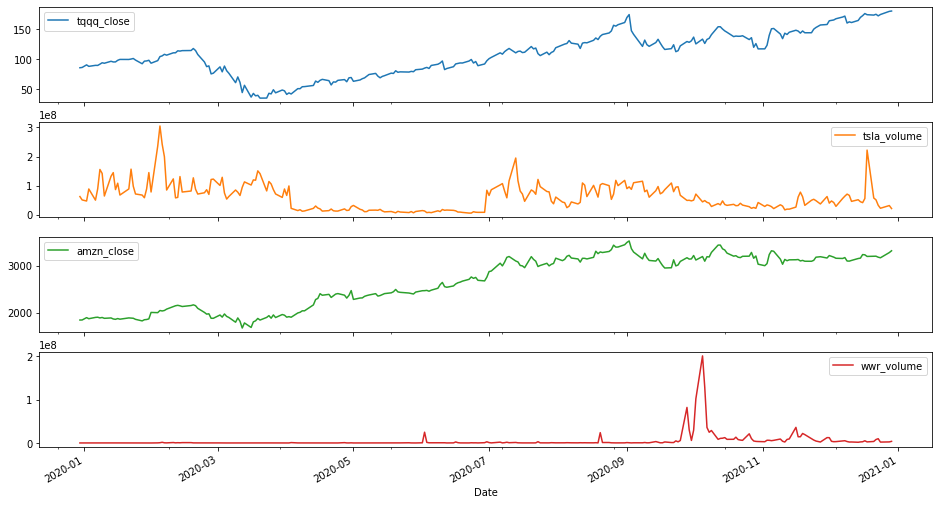

In [31]:
flattened_df[['tqqq_close', 'tsla_volume', 'amzn_close', 'wwr_volume']].plot(subplots=True)

In [32]:
df = flattened_df.apply(lambda row: row.astype(np.float32))
df.dtypes

snap_open      float32
snap_high      float32
snap_low       float32
snap_close     float32
snap_volume    float32
                ...   
spy_open       float32
spy_high       float32
spy_low        float32
spy_close      float32
spy_volume     float32
Length: 85, dtype: object

In [33]:
df.head()

,snap_open,snap_high,snap_low,snap_close,snap_volume,wwr_open,wwr_high,wwr_low,wwr_close,wwr_volume,...,amd_open,amd_high,amd_low,amd_close,amd_volume,spy_open,spy_high,spy_low,spy_close,spy_volume
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,16.049999,16.170000,15.680000,15.890000,15608200.0,2.24,2.24,2.15,2.17,79400.0,...,46.139999,46.169998,44.660000,45.520000,41149700.0,317.029572,317.176819,314.673523,315.193817,49729100.0
2019-12-31,15.780000,16.350000,15.770000,16.330000,18046200.0,2.13,2.23,2.11,2.11,101400.0,...,45.070000,46.090000,44.919998,45.860001,31673200.0,314.653900,316.224579,314.280853,315.959503,57077300.0
2020-01-02,16.620001,16.950001,16.459999,16.780001,26062600.0,2.12,2.39,2.10,2.35,225300.0,...,46.860001,49.250000,46.630001,49.099998,80331104.0,317.608704,318.933960,316.617218,318.914307,59151200.0
2020-01-03,16.430000,17.100000,16.350000,16.750000,19761500.0,2.28,2.34,2.12,2.31,154800.0,...,48.029999,49.389999,47.540001,48.599998,73127400.0,315.272369,317.706909,315.213470,316.499451,77709696.0
2020-01-06,16.650000,16.790001,16.410000,16.780001,15952600.0,2.35,2.45,2.25,2.30,186900.0,...,48.020000,48.860001,47.860001,48.389999,47934900.0,314.614624,317.795258,314.487000,317.706909,55653900.0


In [34]:
df.index

DatetimeIndex(['2019-12-30', '2019-12-31', '2020-01-02', '2020-01-03',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13',
               ...
               '2020-12-15', '2020-12-16', '2020-12-17', '2020-12-18',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-28', '2020-12-29'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

In [35]:
df.head()

,snap_open,snap_high,snap_low,snap_close,snap_volume,wwr_open,wwr_high,wwr_low,wwr_close,wwr_volume,...,amd_open,amd_high,amd_low,amd_close,amd_volume,spy_open,spy_high,spy_low,spy_close,spy_volume
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,16.049999,16.170000,15.680000,15.890000,15608200.0,2.24,2.24,2.15,2.17,79400.0,...,46.139999,46.169998,44.660000,45.520000,41149700.0,317.029572,317.176819,314.673523,315.193817,49729100.0
2019-12-31,15.780000,16.350000,15.770000,16.330000,18046200.0,2.13,2.23,2.11,2.11,101400.0,...,45.070000,46.090000,44.919998,45.860001,31673200.0,314.653900,316.224579,314.280853,315.959503,57077300.0
2020-01-02,16.620001,16.950001,16.459999,16.780001,26062600.0,2.12,2.39,2.10,2.35,225300.0,...,46.860001,49.250000,46.630001,49.099998,80331104.0,317.608704,318.933960,316.617218,318.914307,59151200.0
2020-01-03,16.430000,17.100000,16.350000,16.750000,19761500.0,2.28,2.34,2.12,2.31,154800.0,...,48.029999,49.389999,47.540001,48.599998,73127400.0,315.272369,317.706909,315.213470,316.499451,77709696.0
2020-01-06,16.650000,16.790001,16.410000,16.780001,15952600.0,2.35,2.45,2.25,2.30,186900.0,...,48.020000,48.860001,47.860001,48.389999,47934900.0,314.614624,317.795258,314.487000,317.706909,55653900.0


### Feature Engineering

In [36]:
len(df.columns)

85

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [37]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp)).astype(np.float32)
index_timestamp_seconds

array([1.5776820e+09, 1.5777684e+09, 1.5779412e+09, 1.5780276e+09,
       1.5782868e+09, 1.5783732e+09, 1.5784596e+09, 1.5785460e+09,
       1.5786324e+09, 1.5788916e+09, 1.5789780e+09, 1.5790644e+09,
       1.5791508e+09, 1.5792372e+09, 1.5795828e+09, 1.5796692e+09,
       1.5797556e+09, 1.5798420e+09, 1.5801012e+09, 1.5801876e+09,
       1.5802740e+09, 1.5803604e+09, 1.5804468e+09, 1.5807060e+09,
       1.5807924e+09, 1.5808788e+09, 1.5809652e+09, 1.5810516e+09,
       1.5813108e+09, 1.5813972e+09, 1.5814836e+09, 1.5815700e+09,
       1.5816564e+09, 1.5820020e+09, 1.5820884e+09, 1.5821748e+09,
       1.5822612e+09, 1.5825204e+09, 1.5826068e+09, 1.5826932e+09,
       1.5827796e+09, 1.5828660e+09, 1.5831252e+09, 1.5832116e+09,
       1.5832980e+09, 1.5833844e+09, 1.5834708e+09, 1.5837263e+09,
       1.5838129e+09, 1.5838991e+09, 1.5839857e+09, 1.5840719e+09,
       1.5843313e+09, 1.5844175e+09, 1.5845041e+09, 1.5845903e+09,
       1.5846769e+09, 1.5849359e+09, 1.5850225e+09, 1.5851087e

In [38]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

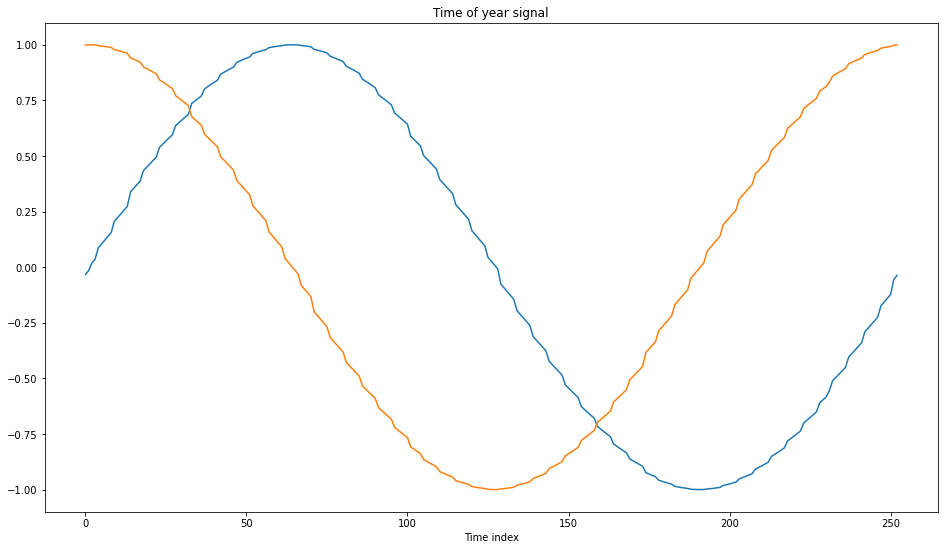

In [39]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

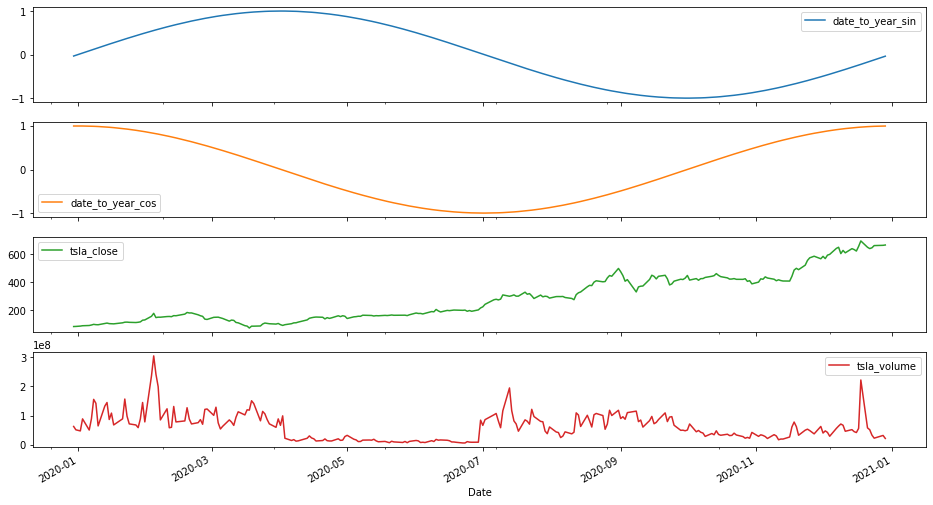

In [40]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df[['date_to_year_sin', 'date_to_year_cos', 'tsla_close', 'tsla_volume']].plot(subplots=True)

In [41]:
df.dtypes

snap_open           float32
snap_high           float32
snap_low            float32
snap_close          float32
snap_volume         float32
                     ...   
spy_low             float32
spy_close           float32
spy_volume          float32
date_to_year_sin    float32
date_to_year_cos    float32
Length: 87, dtype: object

### Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [42]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [43]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

We can use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to visualize the probability density of the data at different values. Using a [seaborn violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

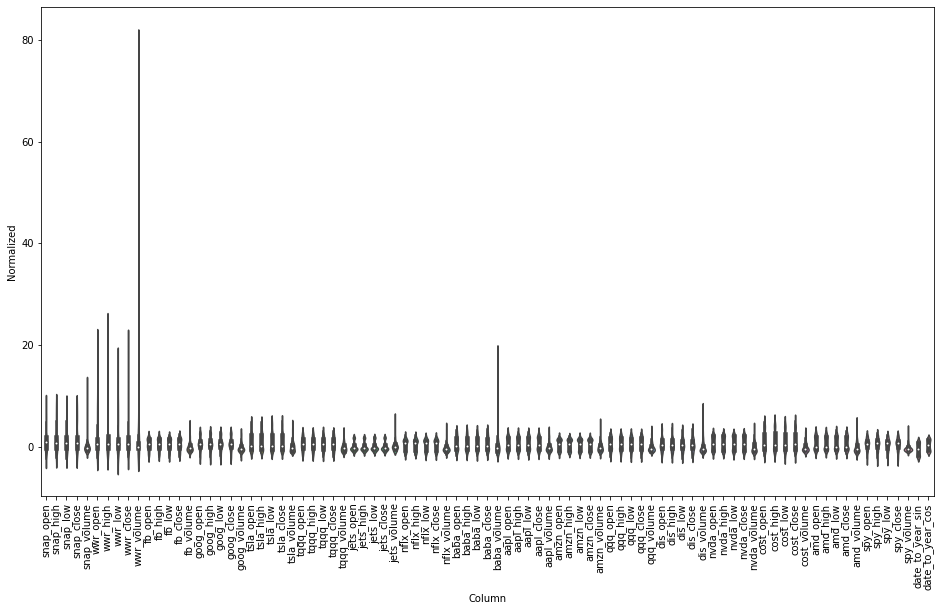

In [44]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

In [45]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='amzn_close', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [days]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

### Single step models



In [46]:
label_columns = ['amzn_close']

In [47]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['amzn_close']

In [48]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 87)
Labels shape (batch, time, features): (32, 1, 1)


#### baseline model

Need something simple to compare more complex models against

In [49]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [50]:
baseline = Baseline(label_index=column_indices[label_columns[0]])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 0.0231 - mean_absolute_error: 0.1166


In [118]:
wide_window = WindowGenerator(
    input_width=3, label_width=3, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [1 2 3]
Label column name(s): ['amzn_close']

In [119]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 87)
Output shape: (32, 1, 87)


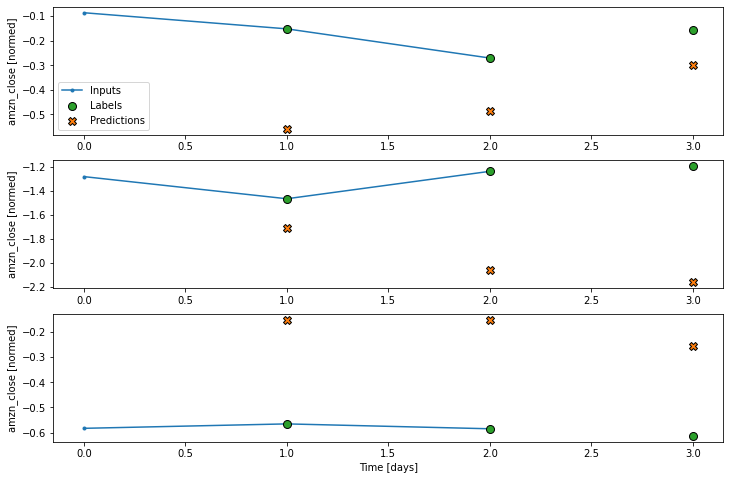

In [120]:
wide_window.plot(baseline)

In [121]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [122]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 87)
Output shape: (32, 1, 1)


In [123]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=0):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.SGD(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [124]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
6/6 [==============================] - 1s 45ms/step - loss: 1.6370 - mean_absolute_error: 0.9982 - val_loss: 9.1109 - val_mean_absolute_error: 1.8460
Epoch 2/100
6/6 [==============================] - 0s 21ms/step - loss: 0.9456 - mean_absolute_error: 0.7469 - val_loss: 8.5664 - val_mean_absolute_error: 1.7436
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 0.8807 - mean_absolute_error: 0.7175 - val_loss: 8.6438 - val_mean_absolute_error: 1.7480
Epoch 4/100
6/6 [==============================] - 0s 22ms/step - loss: 0.8152 - mean_absolute_error: 0.6885 - val_loss: 8.0590 - val_mean_absolute_error: 1.6406
Epoch 5/100
6/6 [==============================] - 0s 23ms/step - loss: 0.7758 - mean_absolute_error: 0.6649 - val_loss: 7.7017 - val_mean_absolute_error: 1.5737
Epoch 6/100
6/6 [==============================] - 0s 23ms/step - loss: 0.8023 - mean_absolute_error: 0.6746 - val_loss: 8.0486 - val_mean_absolute_error: 1.6281
Epoch 7/100
6/6 [===========

In [125]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 3, 87)
Output shape: (32, 3, 87)


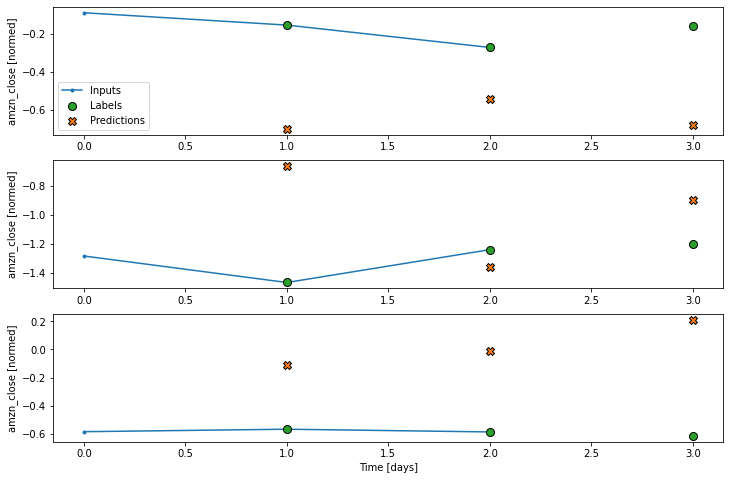

In [126]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input:

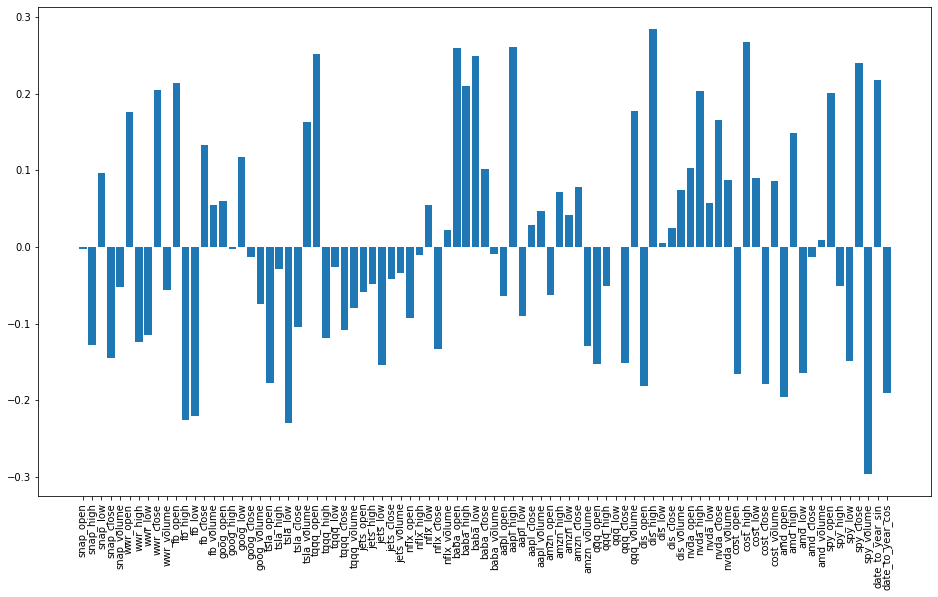

In [127]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `amzn_close`. This is one of the risks of random initialization.

### Dense

In [128]:
%%time
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/100
6/6 [==============================] - 1s 54ms/step - loss: 0.8099 - mean_absolute_error: 0.6903 - val_loss: 6.2164 - val_mean_absolute_error: 1.3656
Epoch 2/100
6/6 [==============================] - 0s 22ms/step - loss: 0.7506 - mean_absolute_error: 0.6454 - val_loss: 6.1822 - val_mean_absolute_error: 1.3487
Epoch 3/100
6/6 [==============================] - 0s 22ms/step - loss: 0.7014 - mean_absolute_error: 0.6183 - val_loss: 6.2044 - val_mean_absolute_error: 1.3553
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 0.6837 - mean_absolute_error: 0.6058 - val_loss: 6.0696 - val_mean_absolute_error: 1.2979
Epoch 5/100
6/6 [==============================] - 0s 22ms/step - loss: 0.7102 - mean_absolute_error: 0.6231 - val_loss: 6.0990 - val_mean_absolute_error: 1.3089
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.7050 - mean_absolute_error: 0.6216 - val_loss: 6.1636 - val_mean_absolute_error: 1.3342
Epoch 7/100
1/1 [===========

#### Multi-step dense

In [129]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=label_columns)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['amzn_close']

Text(0.5, 1.0, 'Given 3 days as input, predict 1 day into the future.')

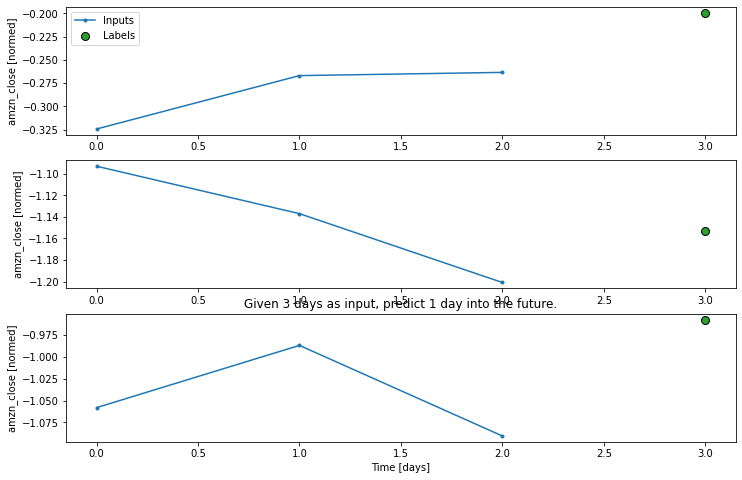

In [130]:
conv_window.plot()
plt.title("Given 3 days as input, predict 1 day into the future.")

You could train a dense model on a multiple-input-step window by adding a layers.Flatten as the first layer of the model

In [131]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [132]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 87)
Output shape: (32, 1, 1)


In [133]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

1/1 [==============================] - 0s 64ms/step - loss: 3.5993 - mean_absolute_error: 1.8821
CPU times: user 3.59 s, sys: 438 ms, total: 4.02 s
Wall time: 3.08 s


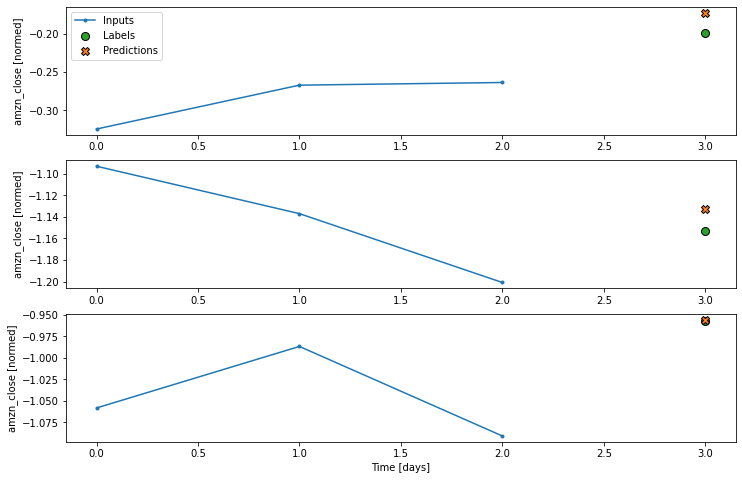

In [134]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape.

In [135]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 3, 87)
Output shape: (32, 1, 1)


### Convolution neural network

In [136]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [137]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 87)
Output shape: (32, 1, 1)


In [138]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 1.7189 - mean_absolute_error: 1.1167
CPU times: user 1.59 s, sys: 141 ms, total: 1.73 s
Wall time: 1.45 s


In [139]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 3, 87)
Labels shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [140]:
LABEL_WIDTH = 3
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=label_columns)

wide_conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [3 4 5]
Label column name(s): ['amzn_close']

In [141]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 5, 87)
Labels shape: (32, 3, 1)
Output shape: (32, 3, 1)


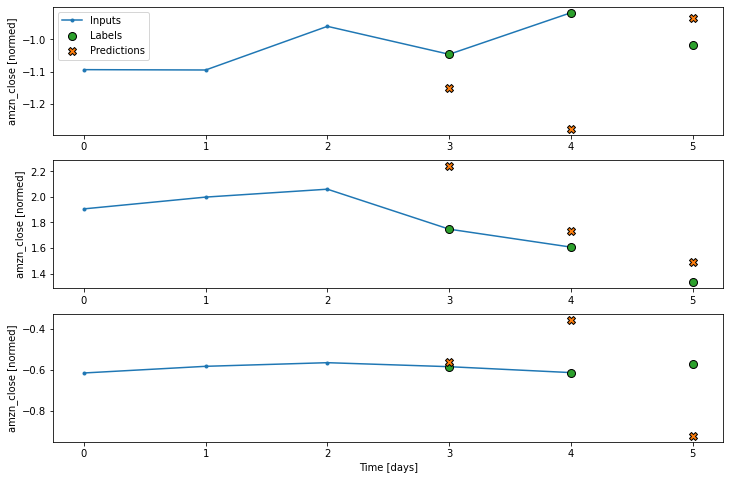

In [142]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

In [143]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [144]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 3, 87)
Output shape: (32, 3, 1)


In [145]:
%%time
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

Epoch 1/100
6/6 [==============================] - 2s 106ms/step - loss: 0.9892 - mean_absolute_error: 0.8536 - val_loss: 0.7572 - val_mean_absolute_error: 0.7530
Epoch 2/100
6/6 [==============================] - 0s 24ms/step - loss: 0.4326 - mean_absolute_error: 0.5531 - val_loss: 0.4625 - val_mean_absolute_error: 0.5283
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 0.2705 - mean_absolute_error: 0.4238 - val_loss: 0.3491 - val_mean_absolute_error: 0.4399
Epoch 4/100
6/6 [==============================] - 0s 25ms/step - loss: 0.1551 - mean_absolute_error: 0.3092 - val_loss: 0.3174 - val_mean_absolute_error: 0.4288
Epoch 5/100
6/6 [==============================] - 0s 25ms/step - loss: 0.1134 - mean_absolute_error: 0.2628 - val_loss: 0.3163 - val_mean_absolute_error: 0.4364
Epoch 6/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0950 - mean_absolute_error: 0.2422 - val_loss: 0.3216 - val_mean_absolute_error: 0.4467
Epoch 7/100
6/6 [==========

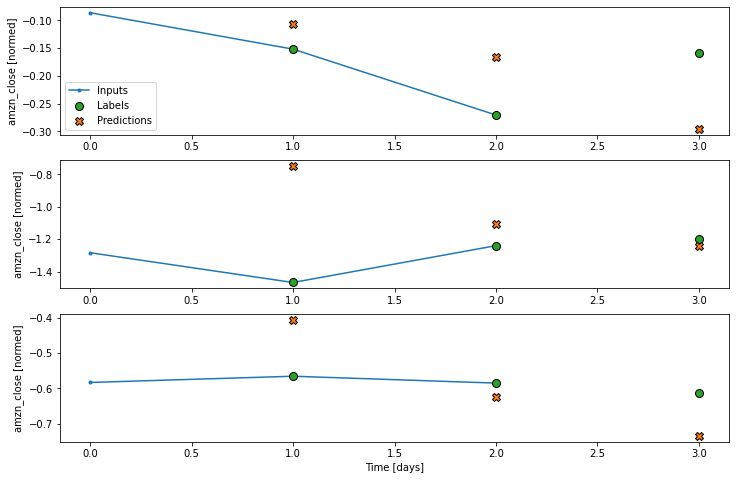

In [146]:
wide_window.plot(lstm_model)

### Performance

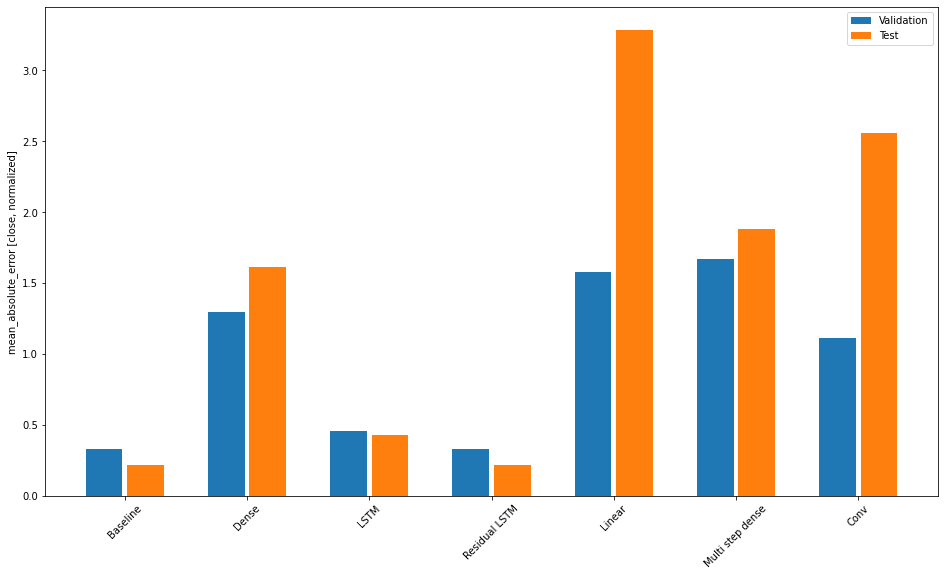

In [147]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [148]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2171
Dense       : 1.6186
LSTM        : 0.4315
Residual LSTM: 0.2170
Linear      : 3.2820
Multi step dense: 1.8821
Conv        : 2.5621


### Multi Output Models

In [149]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 87)
Labels shape (batch, time, features): (32, 7, 87)


In [150]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [151]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 2.1911 - mean_absolute_error: 0.3411


In [152]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [153]:
%%time
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

1/1 [==============================] - 0s 49ms/step - loss: 4.7130 - mean_absolute_error: 1.5210
CPU times: user 19.4 s, sys: 2.92 s, total: 22.3 s
Wall time: 16 s


In [210]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

In [211]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [212]:
%%time
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


2/2 [==============================] - 0s 3ms/step - loss: 8.0841 - mean_absolute_error: 1.5542
CPU times: user 24.7 s, sys: 5.19 s, total: 29.9 s
Wall time: 19.3 s


In [213]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [214]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

2/2 [==============================] - 0s 2ms/step - loss: 2.0994 - mean_absolute_error: 0.3362

CPU times: user 25 s, sys: 5.55 s, total: 30.6 s
Wall time: 19.3 s


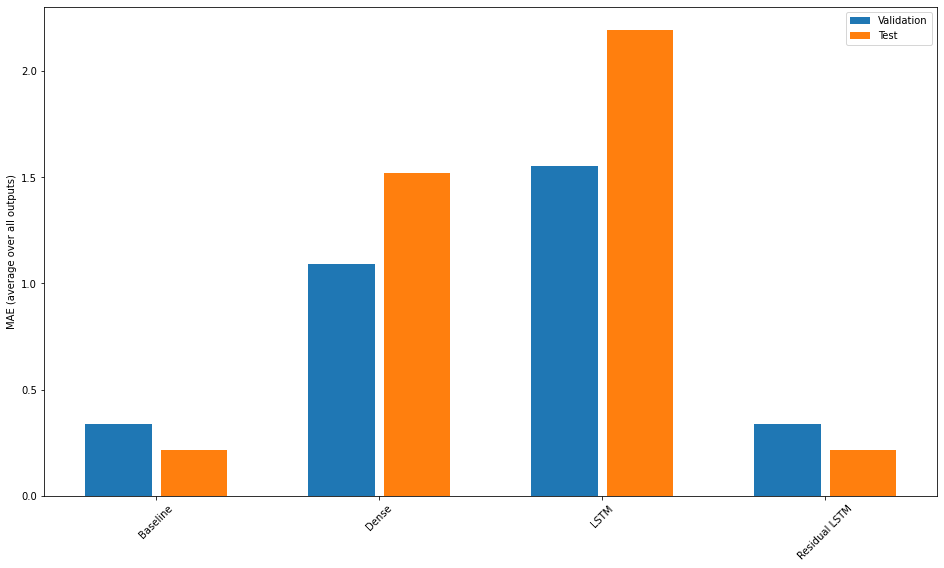

In [215]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Multi Step Models

Total window size: 6
Input indices: [0 1 2]
Label indices: [3 4 5]
Label column name(s): None

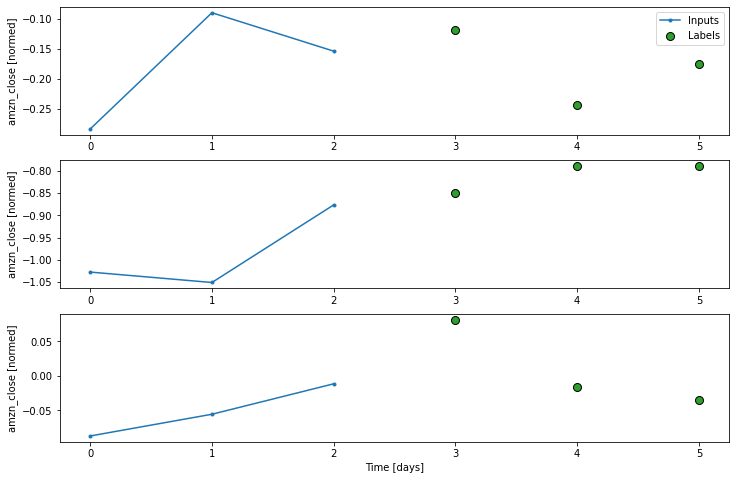

In [216]:
OUT_STEPS = 3
multi_window = WindowGenerator(input_width=3,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

2/2 [==============================] - 0s 2ms/step - loss: 4.1966 - mean_absolute_error: 0.4485


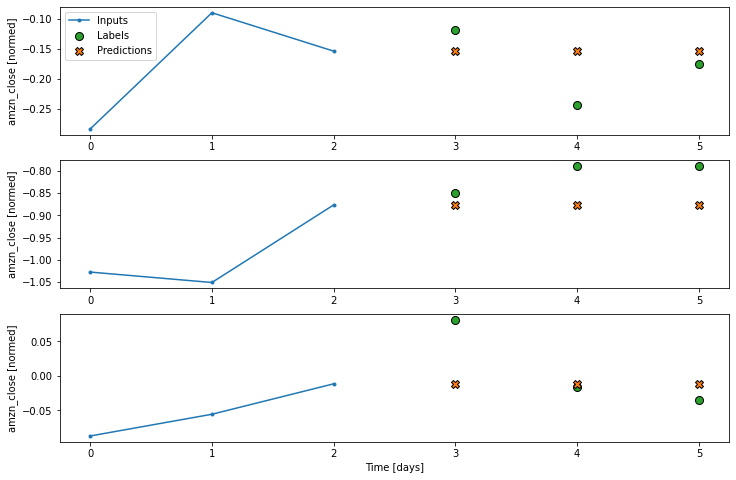

In [217]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

2/2 [==============================] - 0s 2ms/step - loss: 5.2448 - mean_absolute_error: 0.5311


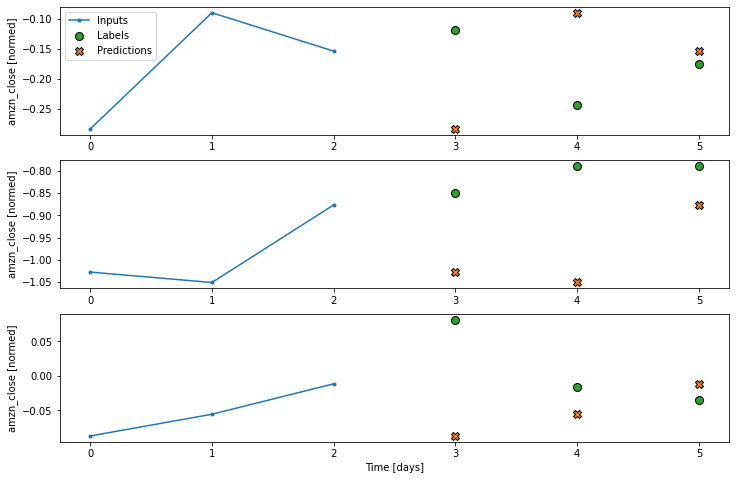

In [218]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

2/2 [==============================] - 0s 2ms/step - loss: 5.5609 - mean_absolute_error: 0.8968
CPU times: user 18.6 s, sys: 2.88 s, total: 21.4 s
Wall time: 15.3 s


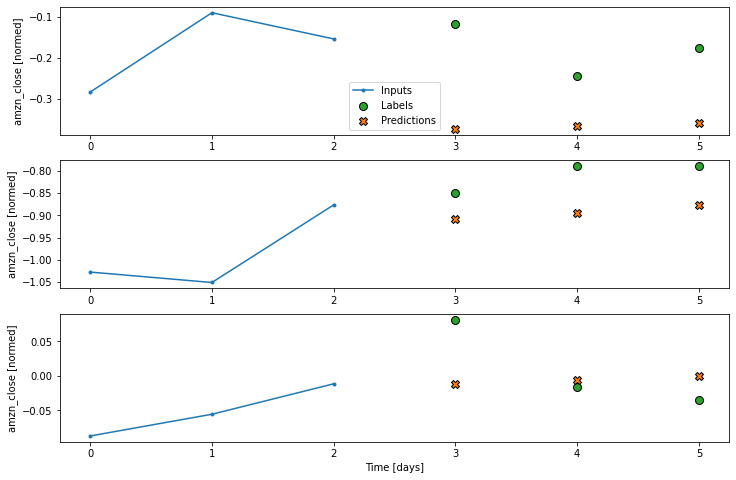

In [219]:
%%time
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

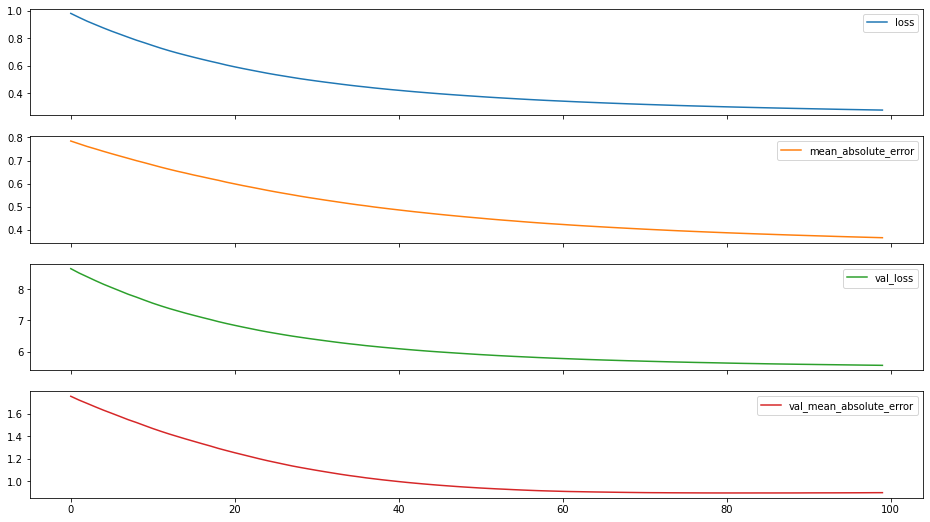

In [220]:
pd.DataFrame(history.history).plot(subplots=True)

### Dense
Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

2/2 [==============================] - 0s 2ms/step - loss: 5.8757 - mean_absolute_error: 0.8675
CPU times: user 20.3 s, sys: 3.16 s, total: 23.5 s
Wall time: 16.4 s


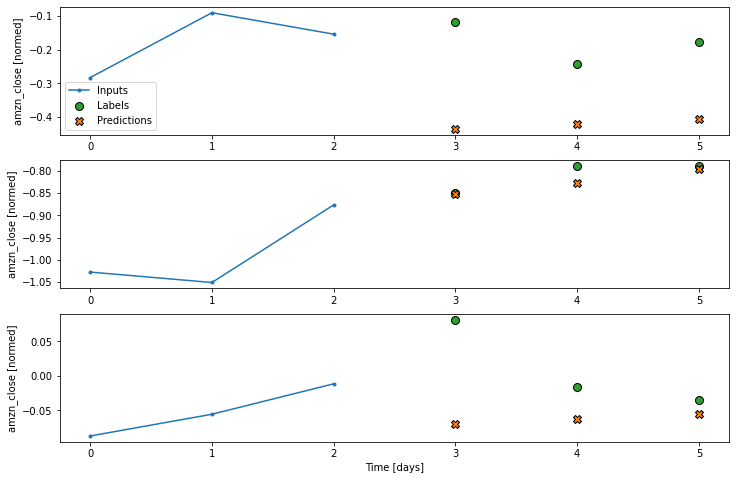

In [221]:
%%time
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

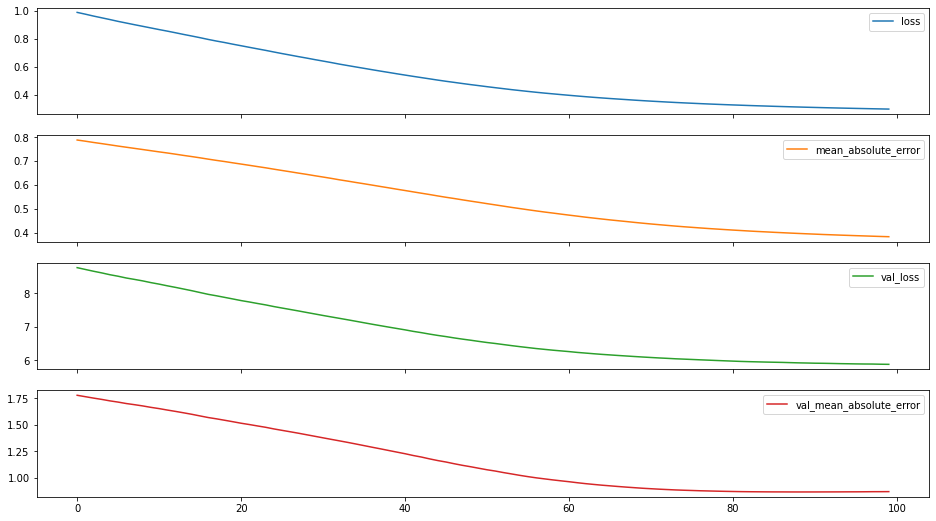

In [222]:
pd.DataFrame(history.history).plot(subplots=True)

### CNN

2/2 [==============================] - 0s 2ms/step - loss: 5.8268 - mean_absolute_error: 0.9095
CPU times: user 20 s, sys: 2.94 s, total: 22.9 s
Wall time: 16.4 s


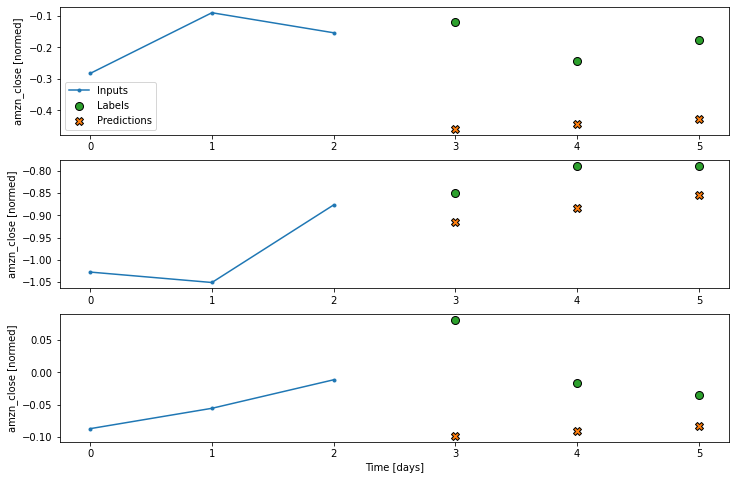

In [223]:
%%time
CONV_WIDTH = 2
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

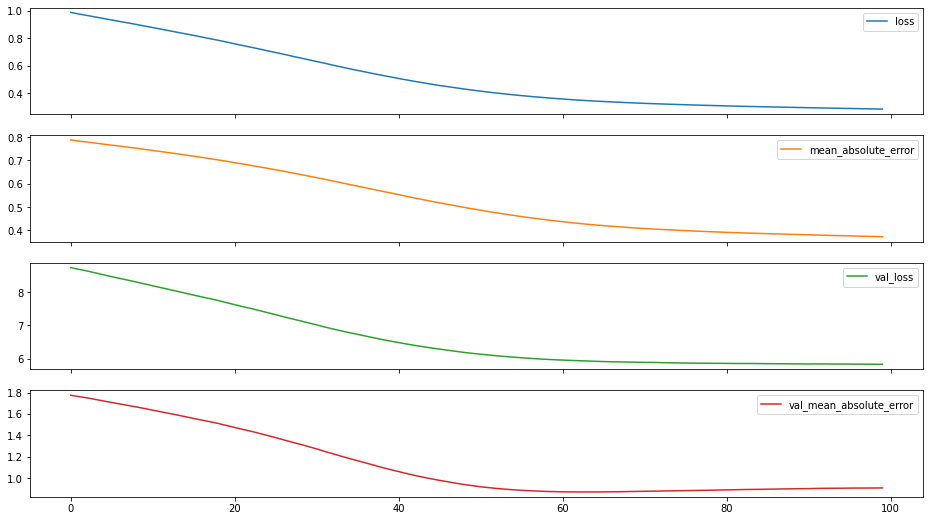

In [224]:
pd.DataFrame(history.history).plot(subplots=True)

### RNN

2/2 [==============================] - 0s 2ms/step - loss: 8.6023 - mean_absolute_error: 1.7394
CPU times: user 22.7 s, sys: 4.51 s, total: 27.3 s
Wall time: 18.1 s


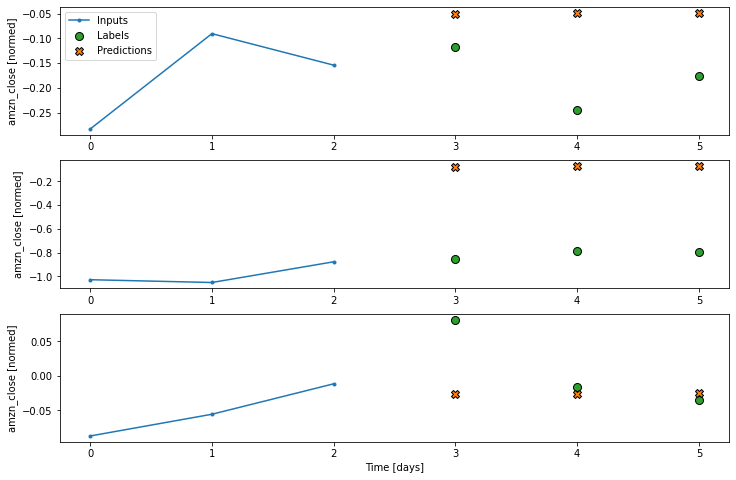

In [225]:
%%time
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

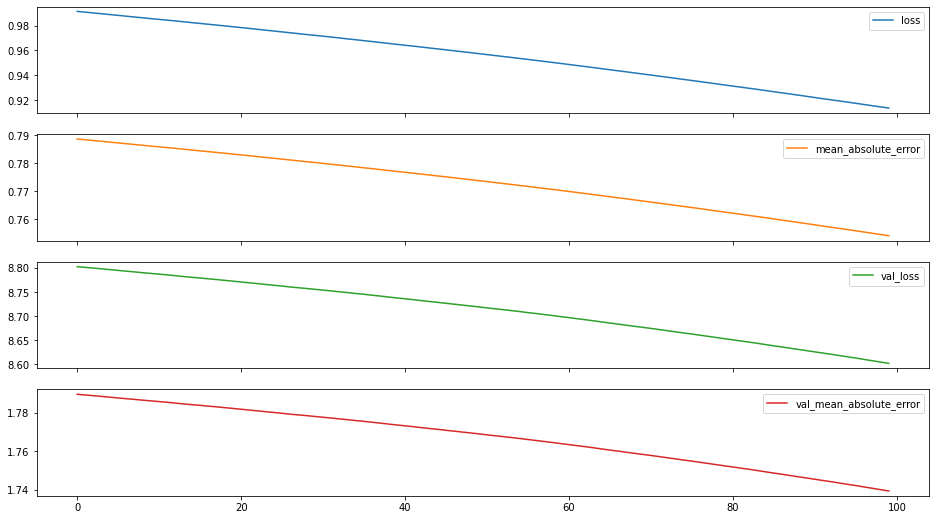

In [226]:
pd.DataFrame(history.history).plot(subplots=True)

### Advanced: Autoregressive model

#### RNN

In [227]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
   
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [228]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [229]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 87])

In [230]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 3, 87)


2/2 [==============================] - 0s 2ms/step - loss: 8.2773 - mean_absolute_error: 1.6516
CPU times: user 23 s, sys: 3.38 s, total: 26.4 s
Wall time: 19.9 s


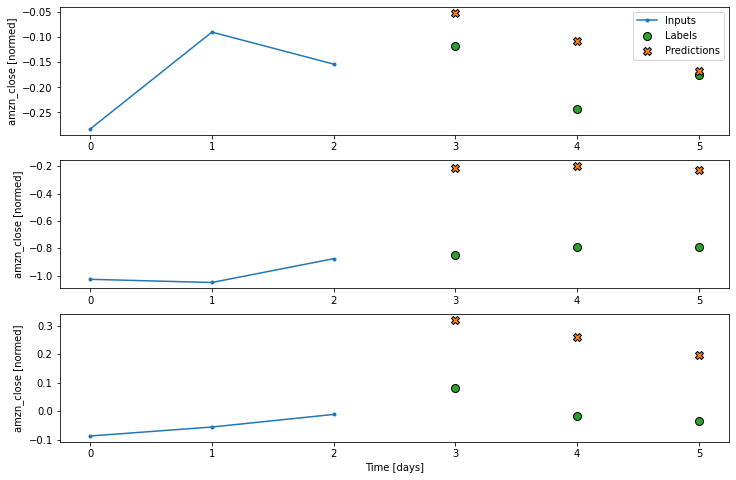

In [231]:
%%time
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

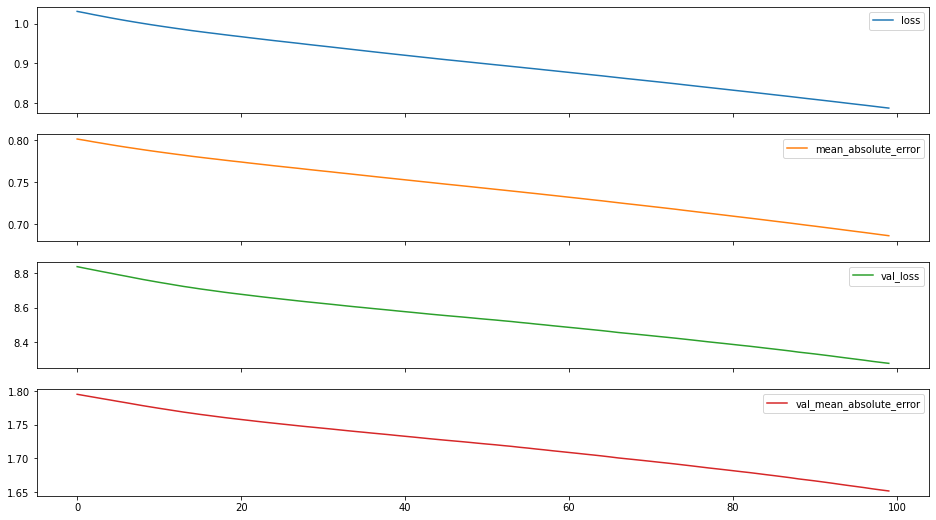

In [232]:
pd.DataFrame(history.history).plot(subplots=True)

### Reference Multi Step LSTM Models

[stacked-lstms-with-dropout](https://www.sciencedirect.com/science/article/pii/S1877050920304865)

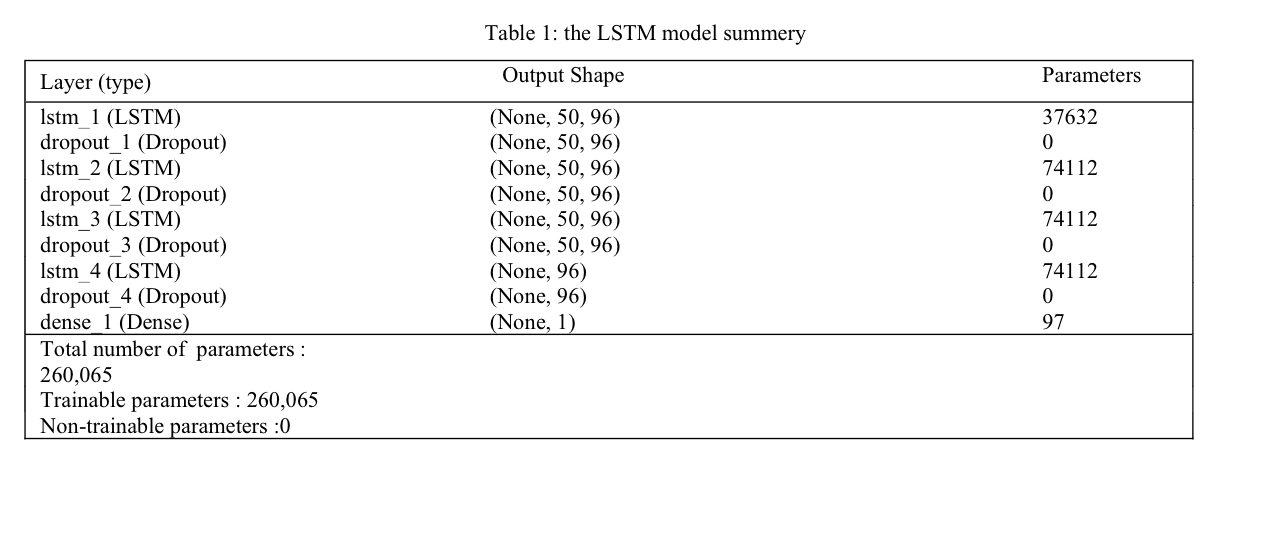

2/2 [==============================] - 0s 4ms/step - loss: 8.8038 - mean_absolute_error: 1.7900
CPU times: user 9.94 s, sys: 535 ms, total: 10.5 s
Wall time: 9.62 s


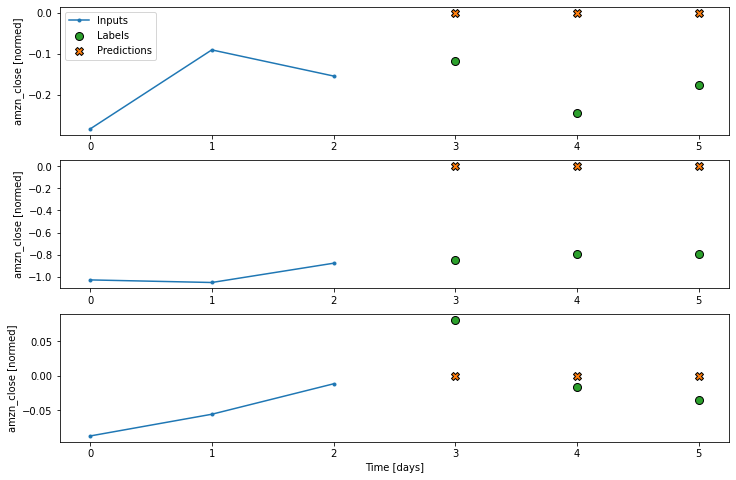

In [233]:
%%time
stacked_lstm_dropout_reference_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(stacked_lstm_dropout_reference_model, multi_window)

IPython.display.clear_output()
multi_val_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.val)
multi_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(stacked_lstm_dropout_reference_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

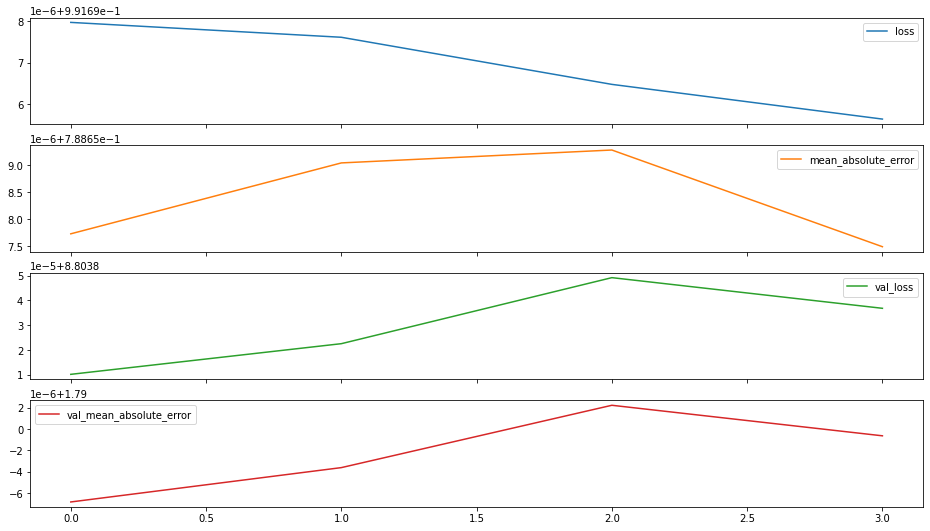

In [234]:
pd.DataFrame(history.history).plot(subplots=True)

### Custom Multi Step Models

Using a CNN with average pooling and dropout layer in front of stacked Bidirectional LSTM layers.

2/2 [==============================] - 0s 2ms/step - loss: 8.8038 - mean_absolute_error: 1.7900
CPU times: user 10.5 s, sys: 462 ms, total: 10.9 s
Wall time: 9.44 s


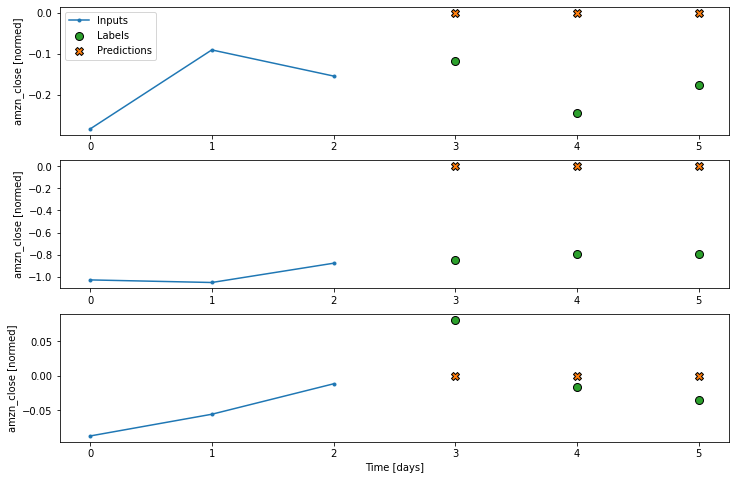

In [235]:
%%time
custom_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.AveragePooling1D(1),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(custom_model, multi_window)

IPython.display.clear_output()
multi_val_performance['custom_model'] = custom_model.evaluate(multi_window.val)
multi_performance['custom_model'] = custom_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(custom_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

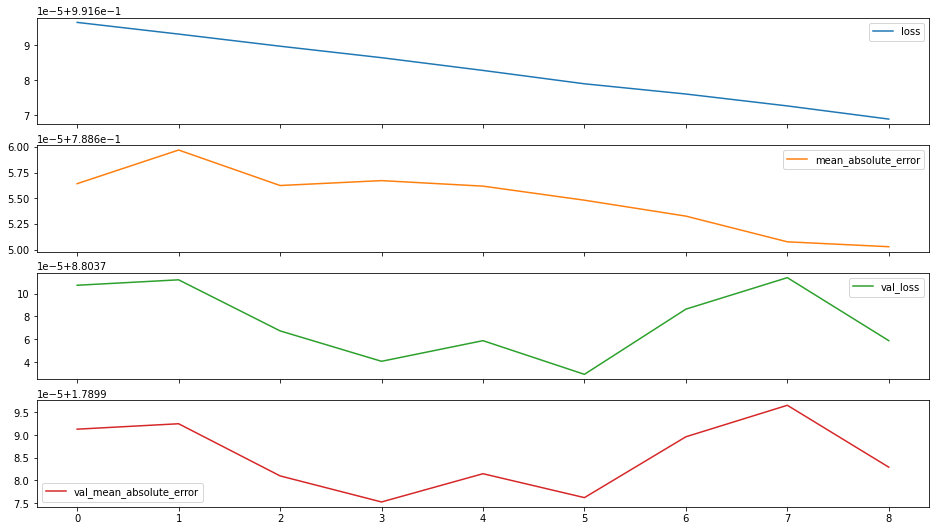

In [236]:
pd.DataFrame(history.history).plot(subplots=True)

### Performance

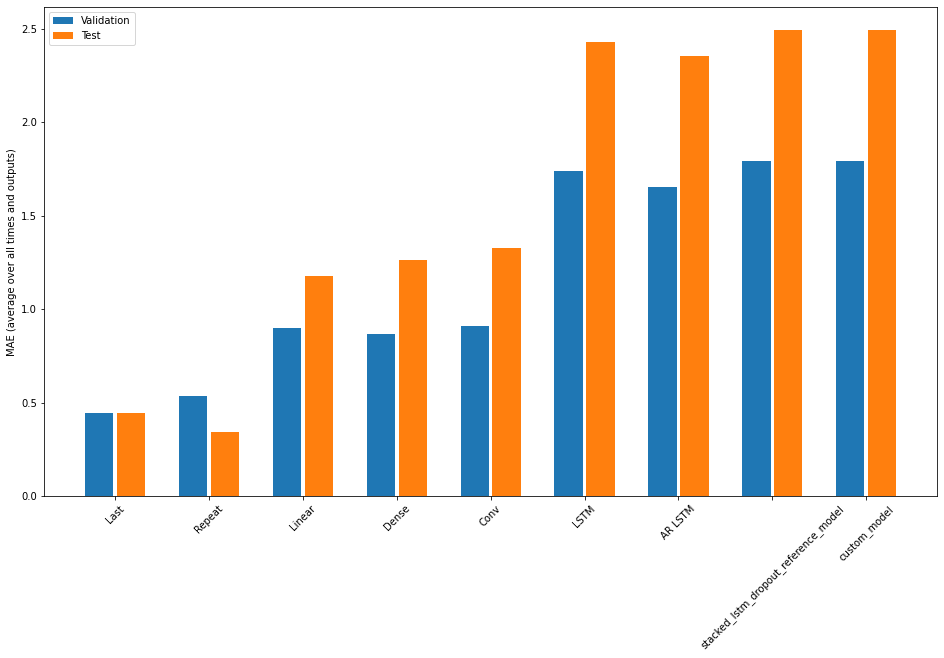

In [237]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [238]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4434
Repeat  : 0.3417
Linear  : 1.1778
Dense   : 1.2621
Conv    : 1.3260
LSTM    : 2.4307
AR LSTM : 2.3542
stacked_lstm_dropout_reference_model: 2.4905
custom_model: 2.4905


Peeking at some other predictions made by the custom model... it predicts all features!

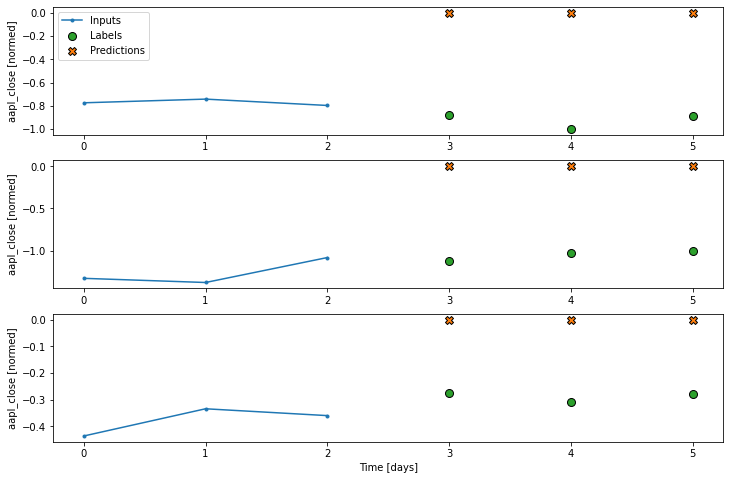

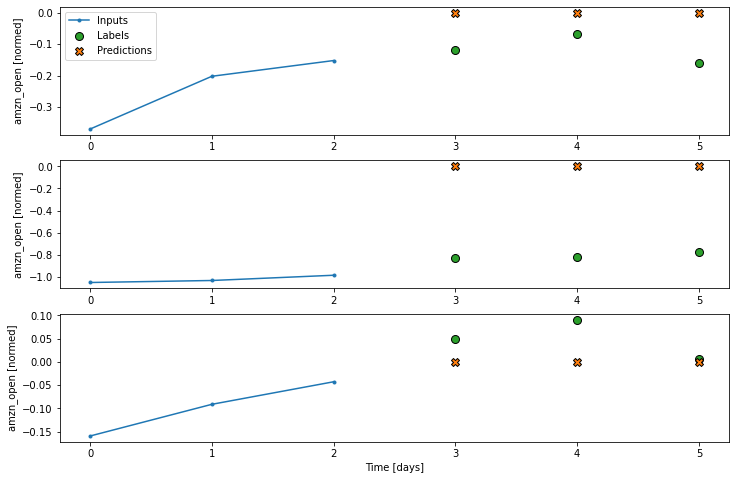

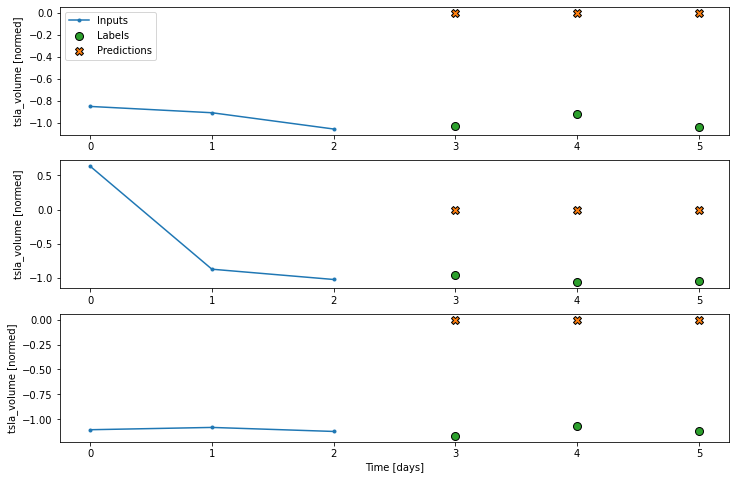

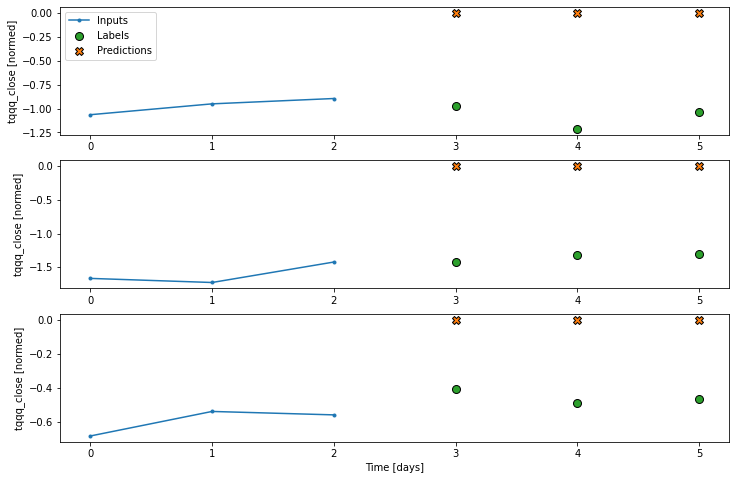

In [239]:
for plot_col in ['aapl_close', 'amzn_open', 'tsla_volume', 'tqqq_close']:
    multi_window.plot(custom_model, plot_col)

Store the trained model weights

In [240]:
custom_model.save_weights('./checkpoints/custom-model')

### Making predictions with the saved model